In [1]:
import numpy as np
import pandas as pd
import random
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Environment(Agent):

    def __init__(self, unique_id: int, pos, model: Model) -> None:
        super().__init__(unique_id, model)
        self.pos = pos

    def get_pos(self):
        return self.pos

In [3]:
# Environment agent is placed on each cell as a place holder
class Nest(Agent):
    '''
    The ant nest. The nest is a special agent that is the home of the ant colony.
    '''
    def __init__(self, unique_id: int, pos, model: Model) -> None:
        '''
        Create a new nest agent.Records the unique_id with super and saves the position of the nest.
        '''
        super().__init__(unique_id, model)
        self.pos = pos

In [4]:
class Food(Agent):
    '''
    The food source. The food source is a special agent that is the source of food for the ant colony.
    '''
    def __init__(self, unique_id: int, model: Model) -> None:
        '''
        Records the unique_id with super and initializes the food source amount to 0.
        '''
        super().__init__(unique_id, model)
        self.amount = 0

    def add(self, amount: int):
        '''
        Adds food to the food source.
        '''
        self.amount += amount

    def eaten(self):
        '''
        The food source is reduced by 1 if there is food available.
        '''
        if self.any_food():
            self.amount -= 1

    def any_food(self):
        '''
        Returns True if there is food available.
        '''
        return self.amount > 0

In [5]:
def get_distance(pos_1, pos_2):
    """
    Get the distance between two positions.

    Args:
        pos_1 (_type_): Coordinate tuple for the first position.
        pos_2 (_type_): Coordinate tuple for the second position.
    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [6]:
class Ant(Agent):
    '''
    The ant agents wander randomly around the environment looking for food.
    If an ant finds food, it will commit to the food source and return to the nest to recruit others
    '''
    def __init__(self, unique_id: int, nest, model: Model) -> None:
        '''
        Create a new ant agent. Records the unique_id with super and saves the position of the ant.
        '''
        super().__init__(unique_id, model)
        self.model = model
        self.pos = nest.pos
        self.state = "UNCOMMITTED"
        self.feeder = None
        self.tandem = False
        self.alpha_ = None
        self.beta_ = None
        self.lambda_ = None

    # defining the step function for the ant agent
    def step(self):
        '''
        The ant moves randomly around the environment. If the ant is uncommitted, it will move randomly.
        If the ant is committed, it will move towards the food source.
        '''
        if self.state == "UNCOMMITTED":
            if self.at_food_loc():
                if self.commit():
                    pass
                else:
                    self.move_random()
            else:
                self.move_random()
        # if the ant is committed, check if random number is less than lamda value
        elif self.state == "COMMITTED_A" or self.state == "COMMITTED_B":
            if self.uncommit():
                pass
            else:
                if self.tandem:
                    self.tandem_run()
                else:
                    if self.recruit_at_loc():
                        pass
                    else:
                        self.move_random()
            
    def commit(self):
        '''
        If the ant is at the food source, it will commit to the food source and return to the nest.
        '''
        if self.pos == self.model.food_locs[0]:
            if self.model.alpha_A > random.random():
                self.state = "COMMITTED_A"
                self.feeder = self.model.food_locs[0]
                self.alpha_ = self.model.alpha_A
                self.beta_ = self.model.beta_A
                self.lambda_ = self.model.lambda_A
                return True
        elif self.pos == self.model.food_locs[1]:
            if self.model.alpha_B > random.random():
                self.state = "COMMITTED_B"
                self.feeder = self.model.food_locs[1]
                self.alpha_ = self.model.alpha_B
                self.beta_ = self.model.beta_B
                self.lambda_ = self.model.lambda_B
                return True    
        return False
    
    def uncommit(self):
        if self.lambda_ > random.random():
            self.state = "UNCOMMITTED"
            self.feeder = None
            self.alpha_ = None
            self.beta_ = None
            self.lambda_ = None
            return True
        return False
    
    def at_food_loc(self):
        '''
        Check if the ant is at the food source.
        '''
        if self.pos == self.model.food_locs[0] or self.pos == self.model.food_locs[1]:
            if self.state == "UNCOMMITTED":
                if self.pos == self.model.food_locs[0]:
                    self.model.foods[0].eaten()
                    return True
                elif self.pos == self.model.food_locs[1]:
                    self.model.foods[1].eaten()
                    return True
            elif self.state == "COMMITTED_A" and self.pos == self.model.food_locs[0]:
                self.feeder = self.model.food_locs[0]
                self.model.foods[0].eaten()
                return True
            elif self.state == "COMMITTED_B" and self.pos == self.model.food_locs[1]:
                self.feeder = self.model.food_locs[1]
                self.model.foods[1].eaten()
                return True
        return False
    
    def tandem_run(self):
        if self.at_food_loc():
            self.tandem = False
        else:
            self.food_move()

    def food_move(self):
        '''
        Move towards the food source.
        '''
        neighbors = [n.get_pos() for n in self.model.grid.iter_neighbors(self.pos, moore=True) if type(n) is Environment]
        min_dist = min([get_distance(self.feeder, n) for n in neighbors])
        min_neighbors = [n for n in neighbors if get_distance(self.feeder, n) == min_dist]
        new_position = random.choice(min_neighbors)
        self.model.grid.move_agent(self, new_position)

    def move_random(self):
        '''
        Move randomly in the environment.
        '''
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def recruit_at_loc(self):
        '''
        Check if there are any ants at the current location that are committed to the same food source.
        '''
        ants = [a for a in self.model.grid.get_cell_list_contents([self.pos]) if type(a) == Ant]
        if len(ants) > 1:
            for ant in ants:
                if ant.state == "UNCOMMITTED" and ant != self:
                    if self.beta_ > random.random():
                        ant.state = self.state
                        ant.feeder = self.feeder
                        ant.alpha_ = self.alpha_
                        ant.beta_ = self.beta_
                        ant.lambda_ = self.lambda_
                        ant.tandem = True
                        return True
        self.move_random()
        return False

In [7]:
class AntModel(Model):
    '''
    A model for simulating the foraging behavior of ants.
    '''
    def __init__(self, N=100, width=50, height=50, alpha_A = 0.0125*60, alpha_B = 0.0125*60, 
               beta_A = 0.015*60, beta_B = 0.006*60, lambda_A = 0.009, lambda_B = 0.038):
        
        
        super().__init__()
        ##assign parameters to local variables
        self.num_agents = N
        self.alpha_A = alpha_A
        self.alpha_B = alpha_B
        self.beta_A = beta_A
        self.beta_B = beta_B
        self.lambda_A = lambda_A
        self.lambda_B = lambda_B
        
        ##Set up of the grid and schedule:
        
        # Use SimultaneousActivation which simulates all the cells
        # computing their next state simultaneously.  This needs to
        # be done because each cell's next state depends on the current
        # state of all its neighbors -- before they've changed.
        self.schedule =  SimultaneousActivation(self)
        
        ##define 2-d grid
        self.grid = MultiGrid(width, height, False)
        
        ##define starting positions for the nest and food locations
        nest_loc = (25, 5)
        self.food_locs = ((10, 40), (40, 40))
        
        self.nest = Nest(self.next_id(), nest_loc, self)
        self.foods = []
        self.grid.place_agent(self.nest, nest_loc)
        self.schedule.add(self.nest)

        ##Add in the ants
        ##create agents
        for i in range(self.num_agents):
            ant = Ant(self.next_id(), self.nest, self) ##instantiate agent i
            self.grid.place_agent(ant, self.nest.pos) ##place ant in nest
            self.schedule.add(ant) ##add ant to schedule
            
        ##add the food locations
        for loc in self.food_locs:
            food = Food(self.next_id(), self) ##instantiate food 
            food.add(100) ##give food value
            self.grid.place_agent(food, loc) ##place food source on grid
            self.schedule.add(food) ##add food to schedule
            self.foods.append(food) ##add food to local list
            
            
        ##add the environment cells
        for (contents, (x, y)) in self.grid.coord_iter():
            cell = Environment(self.next_id(), (x,y), self)
            self.grid.place_agent(cell, (x,y))
            self.schedule.add(cell)
        
        self.running = True
        
        ##Record the data 
        self.dc = DataCollector({"Feeder A:": lambda m: self.foods[0].amount,
                               "Feeder B:": lambda m: self.foods[1].amount})
        
    def step(self):
        '''Have the scheduler advance each cell by one step'''
        
        ##one step
        self.schedule.step()
        
        ##collect data
        self.dc.collect(self)
        
        ##stop when all of the food in a feeder is collected
        if not self.foods[0].any_food() or not self.foods[1].any_food():
            self.running = False


/tmp/ipykernel_176211/2445141329.py:36: UserWarning: Agent 1 is being placed with
place_agent() despite already having the position (25, 5). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(self.nest, nest_loc)
/tmp/ipykernel_176211/2445141329.py:43: UserWarning: Agent 2 is being placed with
place_agent() despite already having the position (25, 5). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(ant, self.nest.pos) ##place ant in nest
/tmp/ipykernel_176211/2445141329.py:43: UserWarning: Agent 3 is being placed with
place_agent() despite already having the position (25, 5). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(ant, self.nest.pos) ##place ant in nest
/tmp/ipykernel_176211/2445141329.py:43: UserWarning: Agent 4 is being placed wit

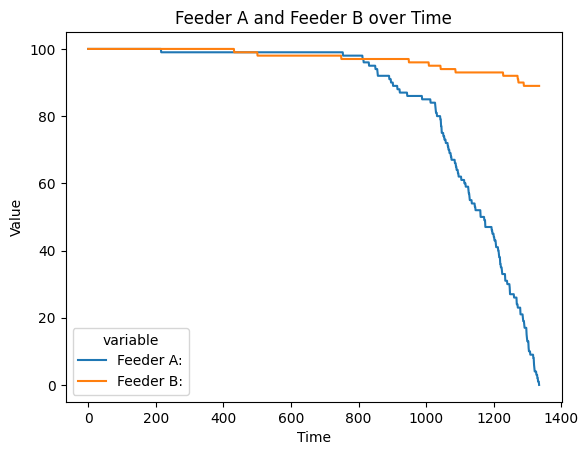

In [13]:
ants = AntModel()
ants.run_model()
data = ants.dc.get_model_vars_dataframe()

data["time"] = np.linspace(0, len(data) - 1, len(data))
datamelt = pd.melt(data, id_vars=["time"], value_vars=["Feeder A:", "Feeder B:"])

sns.lineplot(x="time", y="value", hue="variable", data=datamelt)

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Feeder A and Feeder B over Time")
plt.show()
